#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
training_data_full = pd.read_csv('training.csv')

In [3]:
images = training_data_full['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

images = np.vstack([images.iloc[i] for i in range(len(images))])

In [5]:
keypoints = training_data_full.drop('Image', axis = 1)

In [6]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

In [7]:
def next_batch(X, labels, batch_size):
    
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [8]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def init_gamma(shape):
    init_gamma_val = tf.constant(1, dtype = tf.float32)
    return tf.Variable(init_gamma_val)

def init_beta(shape):
    init_beta_val = tf.constant(0, dtype = tf.float32)
    return tf.Variable(init_beta_val)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


def bn_layer(input_x, is_training, bn_type = 'normal', decay = 0.999):
    
    """Implements batch normalization. 
    input_x: A Tensor. Is the data to normalize.
    is_training: Bool. Indicates whether we are in training o predictino phase. 
    bn_type: 'normal' or 'convo', indicates over which indeces we take the means. 
              if 'normal', we use only the first index (batch number).
              if 'conv', uses [0,1,2]
    decay: float. decay parameter for the running averages. 
    """
    
    if bn_type == 'normal':
        shape = input_x.shape[1:]
        axes = [0]
    elif bn_type == 'convo':
        shape = input_x.shape[-1]
        axes = [0,1,2]
        
    #running mean and variance to be sued for inference.
    pop_mean = tf.Variable(tf.zeros(shape), trainable=False) 
    pop_var = tf.Variable(tf.ones(shape), trainable=False)
    
    gamma = init_gamma(shape) #in the normalization I am using this is the number of channels. 
    beta = init_beta(shape)
    
    batch_mean, batch_var = tf.nn.moments(input_x, axes)  
    
    def train_phase():
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(input_x, batch_mean, batch_var,
                                                    offset = beta, scale = gamma,
                                                    variance_epsilon=0.0001)
    
    def infer_phase(): 
        return tf.nn.batch_normalization(input_x, pop_mean, pop_var, offset = beta, 
                                  scale = gamma, variance_epsilon=0.0001)
    
        
    return tf.cond(is_training, train_phase, infer_phase)
    

In [11]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)

In [12]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [39]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

convo1_bn = bn_layer(convo1, training, bn_type = 'normal')    
#convo1 = convolutional_layer_with_bn(x_images, [8,8,1,32], is_training = training)
convo1_pool = max_pool_2by2(convo1_bn)   #output of 24 x 24 x 32

convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.

convo2_bn = bn_layer(convo2, training, bn_type = 'normal')    
#convo2 = convolutional_layer_with_bn(convo1_pool, [4,4,32,64], is_training = training) # 4x4 filter, 64 outputs. SAME padding.
convo2_pool = max_pool_2by2(convo2_bn) # 6 x 6 x 64

convo2_flat = tf.reshape(convo2_pool,[-1,6*6*64])

convo2_flat_bn = bn_layer(convo2_flat, training, bn_type='normal')

full_layer_one = tf.nn.relu(normal_full_layer(convo2_flat_bn,1024))

#full_layer_one = tf.nn.relu(normal_full_layer_with_bn(convo2_flat,1024, is_training = training))


# DROPOUT AND OUTPOUT LAYER
#drop_prob = tf.placeholder(tf.float32)
#full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_prob)

#keypoints_pred = normal_full_layer(full_one_dropout,30)
keypoints_pred = normal_full_layer(full_layer_one,30)

In [42]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

In [43]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [44]:
counter = 2

In [32]:
keypoints_mean = keypoints_train.mean()

# Computing error from the mean in order to have a reference. This is the mark I have to beat. 

mean_keypoints_mse = ((keypoints_cv-keypoints_mean)**2).sum(axis = 1).mean()
mean_keypoints_mse

## Training

Currently on step 2000
Train MSE:  9.305197 

CV MSE: 55.872135 

train_losses =  [2527.7842, 44.59074, 32.504192, 24.820585, 47.770237, 22.291718, 17.270071, 20.80441, 18.97765, 16.42134, 14.122369, 21.624735, 13.090026, 10.321592, 18.911974, 23.867962, 9.464927, 9.629934, 13.855001, 10.050628, 9.305197] 

cv_losses =  [2100.8413, 8259.248, 2222.0679, 703.8109, 262.10687, 94.03295, 78.31416, 42.27904, 59.590115, 76.66046, 67.933, 84.1028, 116.1901, 118.47743, 98.92399, 83.252975, 89.71478, 80.55237, 61.974777, 85.47239, 55.872135]


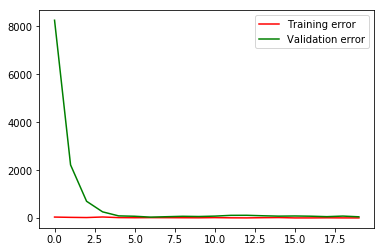

In [46]:
num_steps = 2000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_cnn_0")
    train_losses = []
    cv_losses = []
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 30)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             lr:0.001, training:True})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                      training:False})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    #display(fig)
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_cnn_1"  )
    #counter +=1
    #print(counter)

## Predicting

In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_1")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, drop_prob:0 })
    

In [ ]:
predictions.shape

In [ ]:
x_cv.shape

In [ ]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'y*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

# Adding one more layer

In [51]:
tf.reset_default_graph()

In [52]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
training = tf.placeholder(tf.bool)
drop_rate = tf.placeholder(tf.float32)

In [53]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

In [69]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.

convo2_pool = tf.nn.max_pool(convo2, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 12 x 12 x64

convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

convo3_pool = tf.nn.max_pool(convo3, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME') # 6 x 6 x 128


convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])

full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))

# DROPOUT AND OUTPOUT LAYER

#full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

#keypoints_pred = normal_full_layer(full_one_dropout,30)
pre_pred_bn = bn_layer(full_layer_one, is_training =training)
keypoints_pred = normal_full_layer(pre_pred_bn,30)


In [70]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [71]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [58]:
counter = 0

## Training

KeyboardInterrupt: 

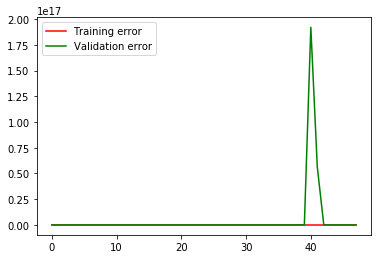

In [74]:
num_steps = 5000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn0")
    train_losses = []
    cv_losses = []
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, 30)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                             lr:1, training:True})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,
                                                      training:False})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_loss, '\n')
    print('CV MSE:', cv_loss, '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    #display(fig)
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_3_lay_cnn_1"  )
    #counter +=1
    #print(counter)

In [67]:
np.sqrt(cv_losses[-1])

2.387357